## 3b.1. Import Thư Viện

In [1]:
import os
import json
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from collections import Counter

print('Libraries imported')

Libraries imported


## 3b.2. Cấu Hình

In [2]:
# Tham số
VAL_SIZE = 0.15
SEED = 42
MAX_FEATURES = 10000  # Giới hạn số features TF-IDF
C_PARAM = 1.0  # Regularization parameter

# Đường dẫn - LOAD TRỰC TIẾP TỪ CSV GỐC
DATA_DIR = './split_augmented_data'
TRAIN_CSV_PATH = os.path.join(DATA_DIR, 'train_augmented.csv')
TEST_CSV_PATH = os.path.join(DATA_DIR, 'test_original.csv')

OUT_DIR = './outputs_svm'
os.makedirs(OUT_DIR, exist_ok=True)

print(f'Configuration set')
print(f'Output directory: {OUT_DIR}')

Configuration set
Output directory: ./outputs_svm


## 3b.3. Load Data từ CSV

In [3]:
print('Loading CSV data...\n')

# Load train (augmented)
df_train = pd.read_csv(TRAIN_CSV_PATH)
print(f'Train CSV loaded: {len(df_train):,} rows')
print(f'   Columns: {list(df_train.columns)}')

# Load test (original)
df_test = pd.read_csv(TEST_CSV_PATH)
print(f'\nTest CSV loaded: {len(df_test):,} rows')
print(f'   Columns: {list(df_test.columns)}')

# Hiển thị sample
print(f'\nSample train data:')
print(df_train.head(2))

Loading CSV data...

Train CSV loaded: 59,995 rows
   Columns: ['review', 'sentiment']

Test CSV loaded: 10,000 rows
   Columns: ['review', 'sentiment']

Sample train data:
                                              review sentiment
0  I've been watching this movie by hoping to fin...  negative
1  A famous orchestra conductor, Daniel Dareus, s...  positive


## 3b.4. Extract Text và Labels

In [4]:
# Auto-detect column names
text_col = df_train.columns[0]  # First column is text
label_col = df_train.columns[1]  # Second column is label

print(f'Detected columns: text="{text_col}", label="{label_col}"')

# Label mapping (binary: negative=0, positive=1)
label2idx = {'negative': 0, 'positive': 1}
idx2label = {0: 'negative', 1: 'positive'}

# Extract từ DataFrame
train_texts = df_train[text_col].astype(str).values
train_labels = df_train[label_col].map(label2idx).values

test_texts = df_test[text_col].astype(str).values
test_labels = df_test[label_col].map(label2idx).values

print(f'Extracted texts and labels:')
print(f'   Train: {len(train_texts):,} samples')
print(f'   Test: {len(test_texts):,} samples')

# Phân phối nhãn
print(f'\nTrain label distribution:')
for label, count in sorted(Counter(train_labels).items()):
    print(f'   {idx2label[label]}: {count:,} ({count/len(train_labels)*100:.1f}%)')

print(f'\nTest label distribution:')
for label, count in sorted(Counter(test_labels).items()):
    print(f'   {idx2label[label]}: {count:,} ({count/len(test_labels)*100:.1f}%)')

# Sample text
print(f'\nSample text:')
print(f'   "{train_texts[0][:150]}..."')

Detected columns: text="review", label="sentiment"
Extracted texts and labels:
   Train: 59,995 samples
   Test: 10,000 samples

Train label distribution:
   negative: 29,997 (50.0%)
   positive: 29,998 (50.0%)

Test label distribution:
   negative: 5,000 (50.0%)
   positive: 5,000 (50.0%)

Sample text:
   "I've been watching this movie by hoping to find a pretty and interesting story yet the story line wasn't good at all. The play of the actors weren't a..."


## 3b.5. Train/Val Split

In [5]:
print(f'Splitting train/val ({100*(1-VAL_SIZE):.0f}%/{100*VAL_SIZE:.0f}%)...\n')

X_train, X_val, y_train, y_val = train_test_split(
    train_texts, train_labels,
    test_size=VAL_SIZE,
    random_state=SEED,
    stratify=train_labels
)

print(f'Train: {len(X_train):,} samples')
print(f'Val: {len(X_val):,} samples')
print(f'Test: {len(test_texts):,} samples')

Splitting train/val (85%/15%)...

Train: 50,995 samples
Val: 9,000 samples
Test: 10,000 samples


## 3b.6. TF-IDF Vectorization

In [6]:
print('Creating TF-IDF features...\n')

vectorizer = TfidfVectorizer(
    max_features=MAX_FEATURES,
    ngram_range=(1, 2),  # Unigrams + Bigrams
    min_df=2,
    sublinear_tf=True,
    strip_accents='unicode'
)

# Fit và transform
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(test_texts)

print(f'TF-IDF features created:')
print(f'   Train shape: {X_train_tfidf.shape}')
print(f'   Val shape: {X_val_tfidf.shape}')
print(f'   Test shape: {X_test_tfidf.shape}')
print(f'   Vocabulary size: {len(vectorizer.vocabulary_):,}')
print(f'   Sparsity: {(1.0 - X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1]))*100:.2f}%')

Creating TF-IDF features...

TF-IDF features created:
   Train shape: (50995, 10000)
   Val shape: (9000, 10000)
   Test shape: (10000, 10000)
   Vocabulary size: 10,000
   Sparsity: 98.49%


## 3b.7. Train SVM

In [7]:
print('\n' + '='*80)
print('TRAINING SVM')
print('='*80)

svm = LinearSVC(
    C=C_PARAM,
    max_iter=1000,
    random_state=SEED,
    class_weight='balanced',
    dual=False
)

print(f'Training with C={C_PARAM}...\n')
svm.fit(X_train_tfidf, y_train)

print('Training completed!')
print('='*80)


TRAINING SVM
Training with C=1.0...

Training completed!


## 3b.8. Evaluate on Validation Set

In [8]:
print('\nVALIDATION SET PERFORMANCE')
print('='*80)

val_preds = svm.predict(X_val_tfidf)
val_acc = accuracy_score(y_val, val_preds)
val_f1 = f1_score(y_val, val_preds, average='macro')

print(f'Accuracy: {val_acc:.4f}')
print(f'Macro F1: {val_f1:.4f}')
print(f'\nClassification Report:')
print(classification_report(y_val, val_preds, target_names=['negative', 'positive']))
print('='*80)


VALIDATION SET PERFORMANCE
Accuracy: 0.8912
Macro F1: 0.8912

Classification Report:
              precision    recall  f1-score   support

    negative       0.89      0.89      0.89      4500
    positive       0.89      0.89      0.89      4500

    accuracy                           0.89      9000
   macro avg       0.89      0.89      0.89      9000
weighted avg       0.89      0.89      0.89      9000



## 3b.9. Evaluate on Test Set (Original - No Augment)


TEST SET PERFORMANCE (KHÔNG AUGMENT - KHÁCH QUAN)

Test Accuracy: 0.8922
Test Macro F1: 0.8922

Classification Report:
              precision    recall  f1-score   support

    negative       0.89      0.89      0.89      5000
    positive       0.89      0.89      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



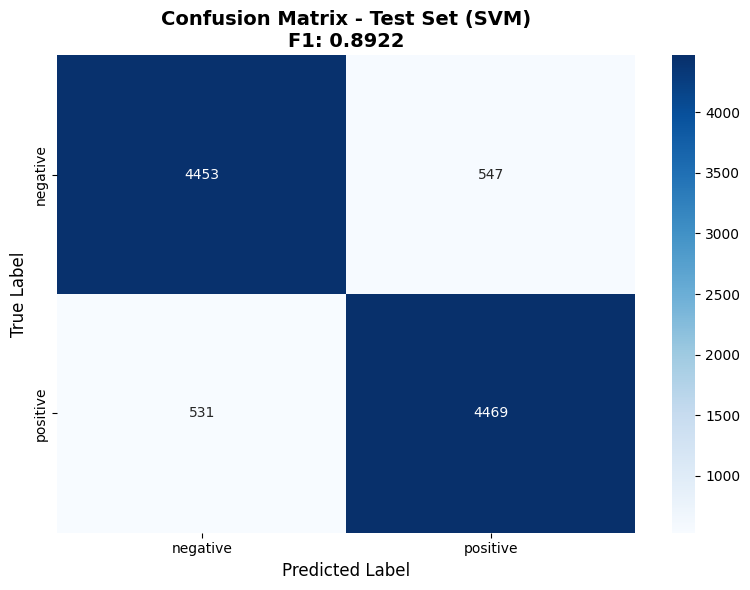

In [9]:
print('\n' + '='*80)
print('TEST SET PERFORMANCE (KHÔNG AUGMENT - KHÁCH QUAN)')
print('='*80)

test_preds = svm.predict(X_test_tfidf)
test_acc = accuracy_score(test_labels, test_preds)
test_f1 = f1_score(test_labels, test_preds, average='macro')

print(f'\nTest Accuracy: {test_acc:.4f}')
print(f'Test Macro F1: {test_f1:.4f}')
print(f'\nClassification Report:')
print(classification_report(test_labels, test_preds, target_names=['negative', 'positive']))

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['negative', 'positive'],
            yticklabels=['negative', 'positive'])
plt.title(f'Confusion Matrix - Test Set (SVM)\nF1: {test_f1:.4f}', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'test_confusion_matrix.png'), dpi=150, bbox_inches='tight')
plt.show()

print('='*80)

## 3b.10. Feature Importance (Top TF-IDF Features)

In [10]:
print('\nTop Features for Each Class:')
print('='*80)

feature_names = vectorizer.get_feature_names_out()
coef = svm.coef_[0]

# Top positive features
top_positive_idx = coef.argsort()[-20:][::-1]
print(f'\nTop 20 features for POSITIVE:')
for idx in top_positive_idx:
    print(f'   {feature_names[idx]:25s} (coef: {coef[idx]:+.4f})')

# Top negative features
top_negative_idx = coef.argsort()[:20]
print(f'\nTop 20 features for NEGATIVE:')
for idx in top_negative_idx:
    print(f'   {feature_names[idx]:25s} (coef: {coef[idx]:+.4f})')

print('='*80)


Top Features for Each Class:

Top 20 features for POSITIVE:
   excellent                 (coef: +3.7331)
   loved this                (coef: +3.3671)
   great                     (coef: +3.1501)
   well worth                (coef: +2.9596)
   refreshing                (coef: +2.9209)
   hilarious                 (coef: +2.7944)
   perfect                   (coef: +2.7841)
   brilliant                 (coef: +2.7711)
   definitely worth          (coef: +2.7406)
   wonderful                 (coef: +2.6399)
   love this                 (coef: +2.6263)
   amazing                   (coef: +2.5724)
   today                     (coef: +2.5450)
   can wait                  (coef: +2.5373)
   of fun                    (coef: +2.5246)
   surprised                 (coef: +2.4810)
   official                  (coef: +2.4764)
   10 out                    (coef: +2.4398)
   highly recommended        (coef: +2.3941)
   wonderfully               (coef: +2.3544)

Top 20 features for NEGATIVE:
   awful

## 3b.11. Save Model & Metadata

In [11]:
# Save model
model_path = os.path.join(OUT_DIR, 'svm_model.pkl')
joblib.dump(svm, model_path)

# Save vectorizer
vectorizer_path = os.path.join(OUT_DIR, 'tfidf_vectorizer.pkl')
joblib.dump(vectorizer, vectorizer_path)

# Save metadata
model_meta = {
    'model_type': 'LinearSVC',
    'val_accuracy': float(val_acc),
    'val_macro_f1': float(val_f1),
    'test_accuracy': float(test_acc),
    'test_macro_f1': float(test_f1),
    'num_classes': 2,
    'max_features': MAX_FEATURES,
    'C': C_PARAM,
    'ngram_range': '(1, 2)',
    'train_samples': len(X_train),
    'val_samples': len(X_val),
    'test_samples': len(test_texts),
    'vocabulary_size': len(vectorizer.vocabulary_),
    'train_augmented': True,
    'test_augmented': False,
    'data_source': 'CSV (split_augmented_data)'
}

meta_path = os.path.join(OUT_DIR, 'meta.json')
with open(meta_path, 'w', encoding='utf-8') as f:
    json.dump(model_meta, f, indent=2, ensure_ascii=False)

print('\nModel & metadata saved:')
print(f'   {model_path}')
print(f'   {vectorizer_path}')
print(f'   {meta_path}')


Model & metadata saved:
   ./outputs_svm\svm_model.pkl
   ./outputs_svm\tfidf_vectorizer.pkl
   ./outputs_svm\meta.json


## 3b.12. Summary

In [12]:
print('\n' + '='*80)
print('SVM TRAINING COMPLETED!')
print('='*80)

print(f'\nSummary:')
print(f'   Model: LinearSVC')
print(f'   Features: TF-IDF (max_features={MAX_FEATURES}, ngrams=1-2)')
print(f'   Data Source: CSV gốc (không qua encoding)')

print(f'\nPerformance:')
print(f'   Val Accuracy: {val_acc:.4f} | Val F1: {val_f1:.4f}')
print(f'   Test Accuracy: {test_acc:.4f} | Test F1: {test_f1:.4f}')

print(f'\nSaved files in {OUT_DIR}:')
for file in sorted(os.listdir(OUT_DIR)):
    file_path = os.path.join(OUT_DIR, file)
    if os.path.isfile(file_path):
        size_kb = os.path.getsize(file_path) / 1024
        print(f'   - {file:35s} ({size_kb:>8.1f} KB)')

print('\n' + '='*80)


SVM TRAINING COMPLETED!

Summary:
   Model: LinearSVC
   Features: TF-IDF (max_features=10000, ngrams=1-2)
   Data Source: CSV gốc (không qua encoding)

Performance:
   Val Accuracy: 0.8912 | Val F1: 0.8912
   Test Accuracy: 0.8922 | Test F1: 0.8922

Saved files in ./outputs_svm:
   - meta.json                           (     0.5 KB)
   - svm_model.pkl                       (    78.8 KB)
   - test_confusion_matrix.png           (    45.3 KB)
   - tfidf_vectorizer.pkl                (   329.9 KB)

